<a href="https://colab.research.google.com/github/sachinkavindaa/Electronic_Project_Level_1/blob/master/IOU%2050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Healthcare AI Datasets/Brain_MRI_Copy

/content/drive/MyDrive/Healthcare AI Datasets/Brain_MRI_Copy


In [4]:
IMAGE_SIZE = (256, 256)

In [5]:
brain_df = pd.read_csv('data_mask.csv')

In [6]:
brain_df.mask_path[1]
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [7]:
brain_df_train = brain_df.drop(columns = ['patient_id'])

In [8]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x : str(x))

In [9]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(brain_df_train, test_size=0.15)
df_train, df_val = train_test_split(brain_df_train, test_size=0.15)

In [10]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)

In [11]:
train_generator=datagen.flow_from_dataframe(
dataframe = df_train,
directory='./', x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='training'
)

valid_generator=datagen.flow_from_dataframe(
dataframe = df_val,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)

test_generator=datagen.flow_from_dataframe(
dataframe = df_test,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
)


Found 259 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Found 56 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3035 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 536 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 534 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

clf_model = Model(base_model.input, outputs=x)
clf_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
clf_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [13]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='clf_model.hdf5',
                            verbose=1,
                            save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=5,
                             min_denta=0.0001,
                             factor=0.2)
my_callbacks = [es, checkpoint, reduce_lr]

In [14]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)


def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [15]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [16]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])



In [17]:
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 1e-4

In [18]:

from tensorflow.python.keras import optimizers as opt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [19]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3035 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 304 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3035 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 304 validated image filenames.
Epoch 1/50
209/208 [==============================] - ETA: 0s - loss: -0.2083 - binary_accuracy: 0.9581 - iou: 0.1200 - dice_coef: 0.2083Found 54 validated image filenames.
Found 54 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 536 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 536 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


208/208 [==============================] - 500s 2s/step - loss: -0.2083 - binary_accuracy: 0.9581 - iou: 0.1200 - dice_coef: 0.2083 - val_loss: -0.0254 - val_binary_accuracy: 0.9870 - val_iou: 0.0135 - val_dice_coef: 0.0256

Epoch 00001: val_loss improved from inf to -0.02537, saving model to unet_brainMRI_seg.hdf5
Epoch 2/50
208/208 [==============================] - 308s 1s/step - loss: -0.3338 - binary_accuracy: 0.9921 - iou: 0.2056 - dice_coef: 0.3338 - val_loss: -0.1062 - val_binary_accuracy: 0.9887 - val_iou: 0.0607 - val_dice_coef: 0.1097

Epoch 00002: val_loss improved from -0.02537 to -0.10619, saving model to unet_brainMRI_seg.hdf5
Epoch 3/50
208/208 [==============================] - 308s 1s/step - loss: -0.4501 - binary_accuracy: 0.9953 - iou: 0.3001 - dice_coef: 0.4501 - val_loss: -0.4915 - val_binary_accuracy: 0.9962 - val_iou: 0.3313 - val_dice_coef: 0.4903

Epoch 00003: val_loss improved from -0.10619 to -0.49150, saving model to unet_brainMRI_seg.hdf5
Epoch 4/50
208/20

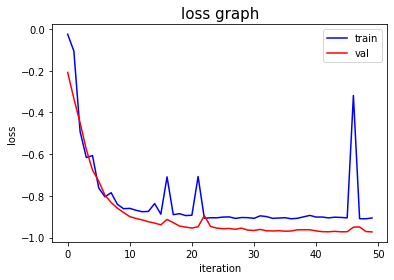

In [29]:
traindice = history.history['dice_coef']
testdice = history.history['val_dice_coef']

trainjaccard = history.history['iou']
testjaccard = history.history['val_iou']

trainloss = history.history['loss']
testloss = history.history['val_loss']
plt.figure(1)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.legend(['train','val'])


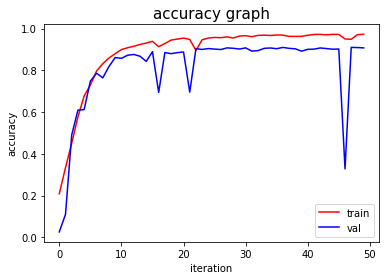

In [30]:
plt.figure(2)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.legend(['train','val'])
plt.show()

In [21]:

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 534 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 534 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 56 validated image filenames.
Found 56 validated image filenames.
36/36 [==============================] - 24s 641ms/step - loss: -0.9603 - binary_accuracy: 0.9987 - iou: 0.9223 - dice_coef: 0.9593
Test lost:  -0.9603246450424194
Test IOU:  0.9987130761146545
Test Dice Coefficent:  0.9222817420959473


In [24]:
test_gen1 = train_generator(df_train, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results1 = model.evaluate(test_gen1, steps=len(df_train) / BATCH_SIZE)
print("Test lost: ",results1[0])
print("Test IOU: ",results1[1])
print("Test Dice Coefficent: ",results1[2])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3035 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 304 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3035 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 304 validated image filenames.
208/208 [==============================] - 92s 440ms/step - loss: -0.9762 - binary_accuracy: 0.9993 - iou: 0.9540 - dice_coef: 0.9762
Test lost:  -0.9761937260627747
Test IOU:  0.9993387460708618
Test Dice Coefficent:  0.9540213346481323


In [25]:
test_gen2 = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results2 = model.evaluate(test_gen2, steps=len(df_val) / BATCH_SIZE)
print("Test lost: ",results2[0])
print("Test IOU: ",results2[1])
print("Test Dice Coefficent: ",results2[2])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 536 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 536 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 54 validated image filenames.
Found 54 validated image filenames.
36/36 [==============================] - 15s 410ms/step - loss: -0.9003 - binary_accuracy: 0.9976 - iou: 0.8200 - dice_coef: 0.8923
Test lost:  -0.900324285030365
Test IOU:  0.9976056218147278
Test Dice Coefficent:  0.8200237154960632
